## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/hepato/hepato_alt_maccs_train.csv")
df_test = pd.read_csv("../../data/train/hepato/hepato_alt_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/hepato/hepato_alt_maccs_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'ALT']
y_train = df_train_all['ALT']

X_test = df_test.loc[:, df_test.columns != 'ALT']
y_test = df_test['ALT']

In [5]:
X_train.shape, y_train.shape

((77, 166), (77,))

In [6]:
X_test.shape, y_test.shape

((21, 166), (21,))

## 3. Metrics 📏

In [8]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 4. Models ⚙️

## 4.1. Ridge Regression

Poor results.

In [11]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['auto', 'cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'auto', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 12.197662702251472
MSE: 311.1720836819582
RMSE: 17.640070399008
R2 Square -0.9569633552513581 

Base model:
MAE: 10.554770358443086
MSE: 209.60484685341345
RMSE: 14.477736247542758
R2 Square -0.3182063105456714 

Train set:
Tuned model:
MAE: 17.734312502611953
MSE: 1022.6009264023972
RMSE: 31.97813200301727
R2 Square 0.595360566851751 

Base model:
MAE: 21.791234568716
MSE: 1740.912100098138
RMSE: 41.724238759959874
R2 Square 0.3111274719621778 



In [13]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.55477,209.604847,14.477736,-0.318206


## 4.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [47]:
# default: 'n_estimators': 100, 'max_depth': None

params = {
    'max_depth': [1, 2, 3, 5],
    'n_estimators': [1, 5, 10, 50, 100, 150],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 1, 'n_estimators': 5} 

Test set:
Tuned model:
MAE: 10.261544868929079
MSE: 159.1402223880797
RMSE: 12.615079166936674
R2 Square -0.0008339433119932682 

Base model:
MAE: 11.905389417928049
MSE: 278.11231434022744
RMSE: 16.67669974366114
R2 Square -0.7490502405229991 

Train set:
Tuned model:
MAE: 18.48928064202275
MSE: 1410.6271933881837
RMSE: 37.55831723317997
R2 Square 0.4418199972454454 

Base model:
MAE: 10.477646226131899
MSE: 514.7564271220948
RMSE: 22.68824424943664
R2 Square 0.7963127711873994 



In [48]:
params = {'max_depth': 2, 'n_estimators': 15} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 8.84799847998615
MSE: 114.2604242403341
RMSE: 10.68926677748919
R2 Square 0.28141541314371976 

Train set:
MAE: 15.89655710476595
MSE: 1003.3339753511049
RMSE: 31.67544751619312
R2 Square 0.6029844286639221 



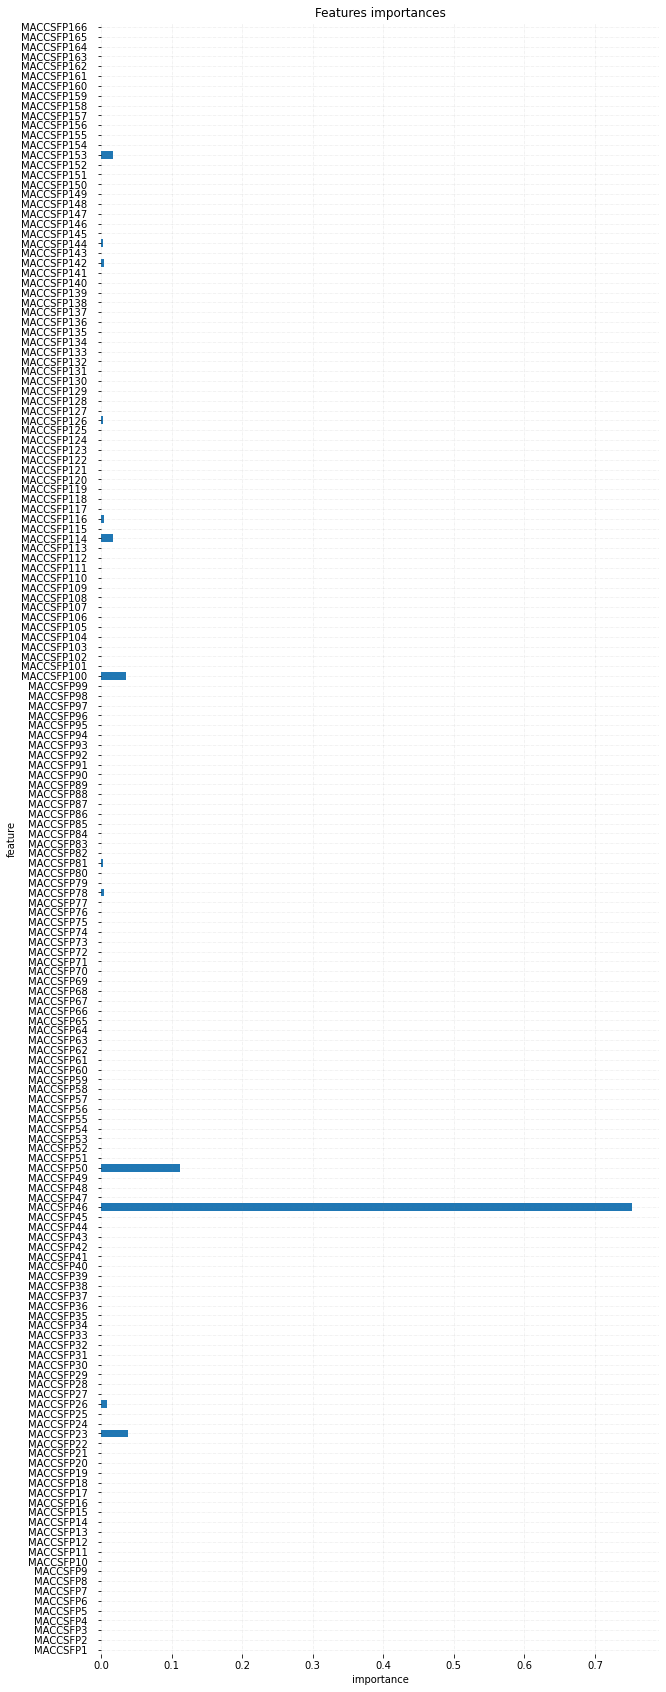

In [49]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [50]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415


## 4.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [110]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.005, 0.01],
    'lambda': [0.6, 0.8],
    'gamma': [0.1, 0.5],
    'max_depth': [5, 10, 15],
    'n_estimators': [10, 50, 100, 120, 150, 200],
    'min_child_weight': [3, 5, 12, 20],
    'colsample_bytree': [0.3],
    'subsample': [0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 12.138574927193778
MSE: 293.7864638097491
RMSE: 17.140200226652812
R2 Square -0.8476250733731634 

Base model:
MAE: 12.233776328677223
MSE: 259.59332031778837
RMSE: 16.111899959898842
R2 Square -0.6325841608888334 

Train set:
Tuned model:
MAE: 13.771175763080644
MSE: 825.878361414111
RMSE: 28.738099474636645
R2 Square 0.6732029637527353 

Base model:
MAE: 7.711574514810139
MSE: 390.87272876836363
RMSE: 19.770501479941363
R2 Square 0.84533309591419 



In [111]:
params = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 5, 
          'min_child_weight': 12, 'n_estimators': 200, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 7.0949164072672515
MSE: 110.63121153794972
RMSE: 10.518137265597446
R2 Square 0.30423955656603907 

Train set:
MAE: 18.531327830723352
MSE: 1705.6876387991394
RMSE: 41.299971414023275
R2 Square 0.32506566200775433 



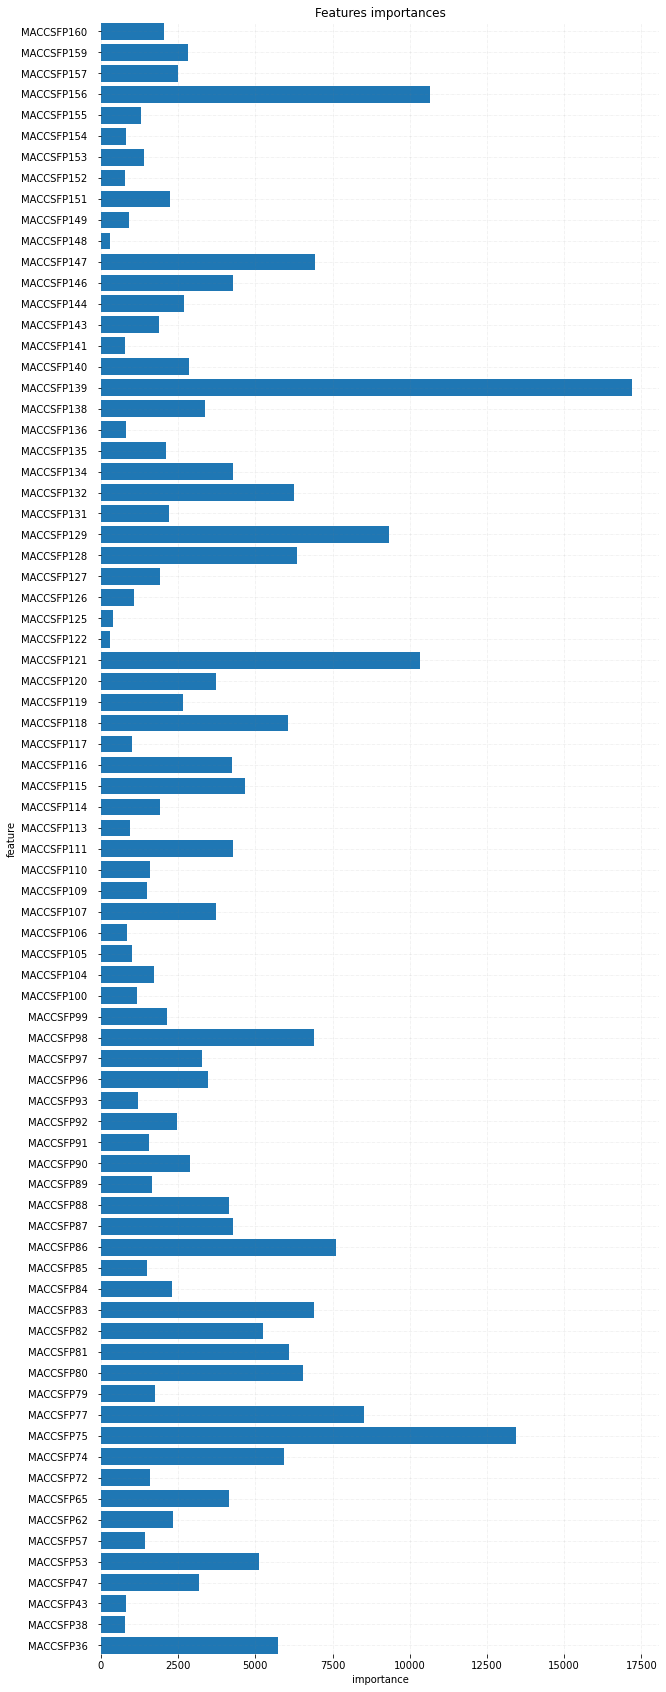

In [112]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [113]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415
2,XGBoost,7.094916,110.631212,10.518137,0.304240


## 4.4. LightGBM

Better results - third model.

In [170]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [10, 15, 35, 60],
    'learning_rate': [0.005, 0.01],
    'max_depth': [5, 10],
    'n_estimators': [5, 10, 20, 35, 50],
    'min_child_samples': [1, 5],
    'reg_alpha': [0.5, 0.7],
    'reg_lambda': [0.01, 0.02],
    'colsample_bytree': [0.25, 0.45],
    'subsample': [0.9],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 1, 'n_estimators': 50, 'num_leaves': 35, 'reg_alpha': 0.5, 'reg_lambda': 0.01, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 9.826484557197315
MSE: 179.8261540824421
RMSE: 13.409927445084932
R2 Square -0.1309279087349169 

Base model:
MAE: 13.68620358457358
MSE: 424.923072301211
RMSE: 20.613662272900733
R2 Square -1.672344098014301 

Train set:
Tuned model:
MAE: 18.778956527119863
MSE: 1181.8483612679593
RMSE: 34.37802148565213
R2 Square 0.532346941388872 

Base model:
MAE: 18.35759383474747
MSE: 1043.7453255210671
RMSE: 32.30704761381125
R2 Square 0.5869938057304412 



In [171]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 5, 
          'min_child_samples': 1, 'n_estimators': 35, 'num_leaves': 35, 'reg_alpha': 0.5, 'reg_lambda': 0.01, 
          'subsample': 0.9}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 9.18183124929872
MSE: 166.45271254574715
RMSE: 12.901655418811462
R2 Square -0.04682224375612165 

Train set:
MAE: 21.193672473764245
MSE: 1472.2875741556004
RMSE: 38.37039971326335
R2 Square 0.4174212108985469 



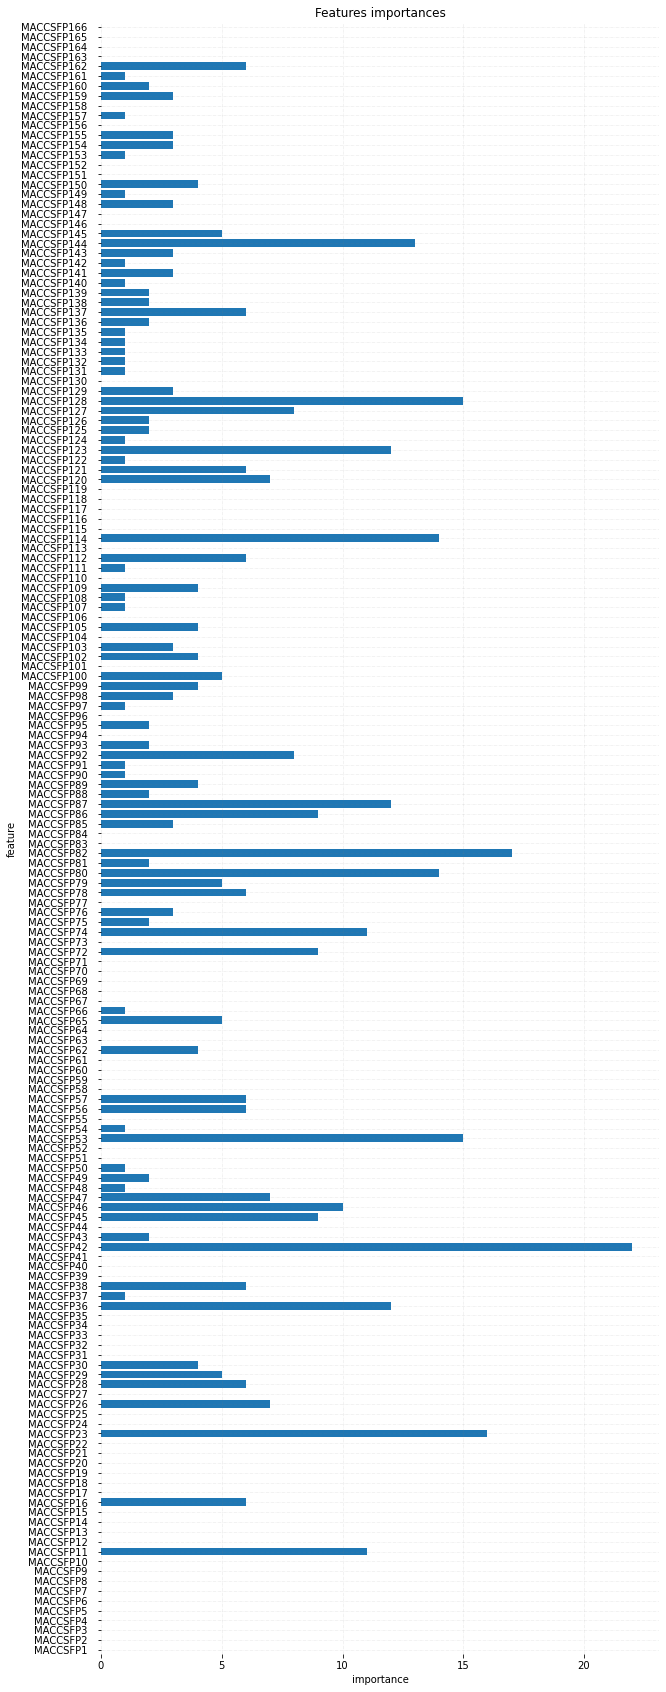

In [172]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [173]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415
2,XGBoost,7.094916,110.631212,10.518137,0.304240
3,LightGBM,9.181831,166.452713,12.901655,-0.046822


## 4.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [196]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0

params = {
    'learning_rate': [0.001, 0.005, 0.1],
    'max_depth': [5, 15, 20, 35],
    'l2_regularization': [0, 0.1, 0.2],
    'min_samples_leaf':[1, 2, 8],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.2, 'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 8} 

Test set:
Tuned model:
MAE: 17.60962946948957
MSE: 617.4127156365486
RMSE: 24.847790960899292
R2 Square -2.8829127769761027 

Base model:
MAE: 13.686203563911493
MSE: 424.9230717622491
RMSE: 20.6136622598278
R2 Square -1.672344094624766 

Train set:
Tuned model:
MAE: 11.683588381296333
MSE: 551.867182604053
RMSE: 23.491853537004122
R2 Square 0.7816281814572178 

Base model:
MAE: 18.357593859583137
MSE: 1043.745326955065
RMSE: 32.30704763600451
R2 Square 0.5869938051630135 



In [197]:
params = {'l2_regularization': 0.1, 'learning_rate': 0.005, 'max_depth': 35, 'min_samples_leaf': 1} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 9.88844078248584
MSE: 180.92080754386203
RMSE: 13.45068056062079
R2 Square -0.13781219181503834 

Train set:
MAE: 18.97912149511552
MSE: 1221.5448133637753
RMSE: 34.950605336156556
R2 Square 0.5166392009993166 



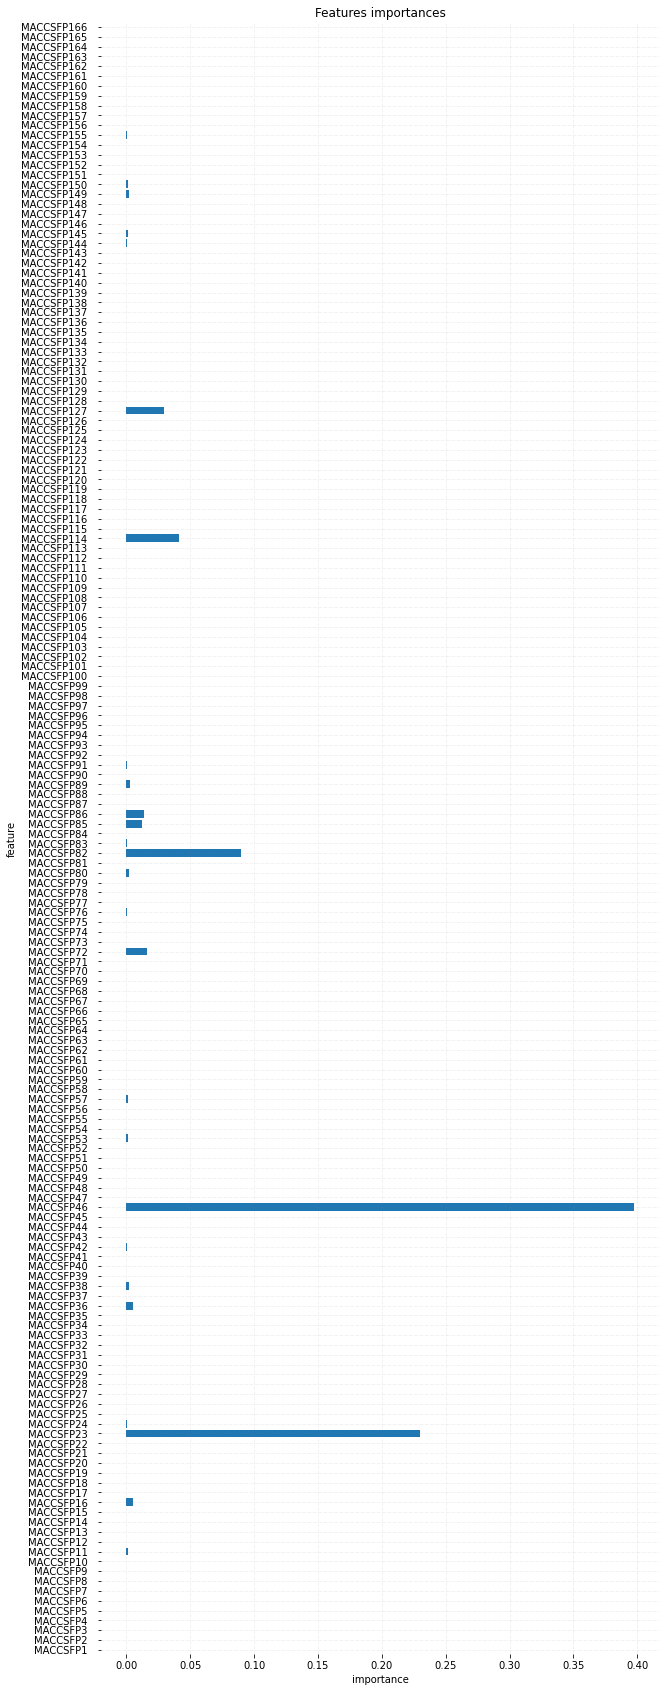

In [198]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [199]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415
2,XGBoost,7.094916,110.631212,10.518137,0.304240
3,LightGBM,9.181831,166.452713,12.901655,-0.046822
4,HistGradient Boosting Regressor,9.888441,180.920808,13.450681,-0.137812


## 4.6. Support Vector Regression

Better results - fifth model.

In [205]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0],
    'epsilon': [0.1, 0.001, 0.0001],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 2.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 9.901280175172788
MSE: 147.71663475241834
RMSE: 12.153873240758205
R2 Square 0.071009077192831 

Base model:
MAE: 10.788112992591179
MSE: 163.3842373031321
RMSE: 12.782184371347961
R2 Square -0.02752458204032604 

Train set:
Tuned model:
MAE: 21.25804541865632
MSE: 2555.765846259498
RMSE: 50.55458284131616
R2 Square -0.011307164495127031 

Base model:
MAE: 22.072236126581117
MSE: 2629.0632850261914
RMSE: 51.27439209806579
R2 Square -0.04031069197883097 



In [211]:
params = {'C': 6.5, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 8.51987396508483
MSE: 129.6969028551043
RMSE: 11.388454805420457
R2 Square 0.1843352939190721 

Train set:
MAE: 19.231043116799743
MSE: 2360.226867906305
RMSE: 48.58216615082437
R2 Square 0.06606689151867406 



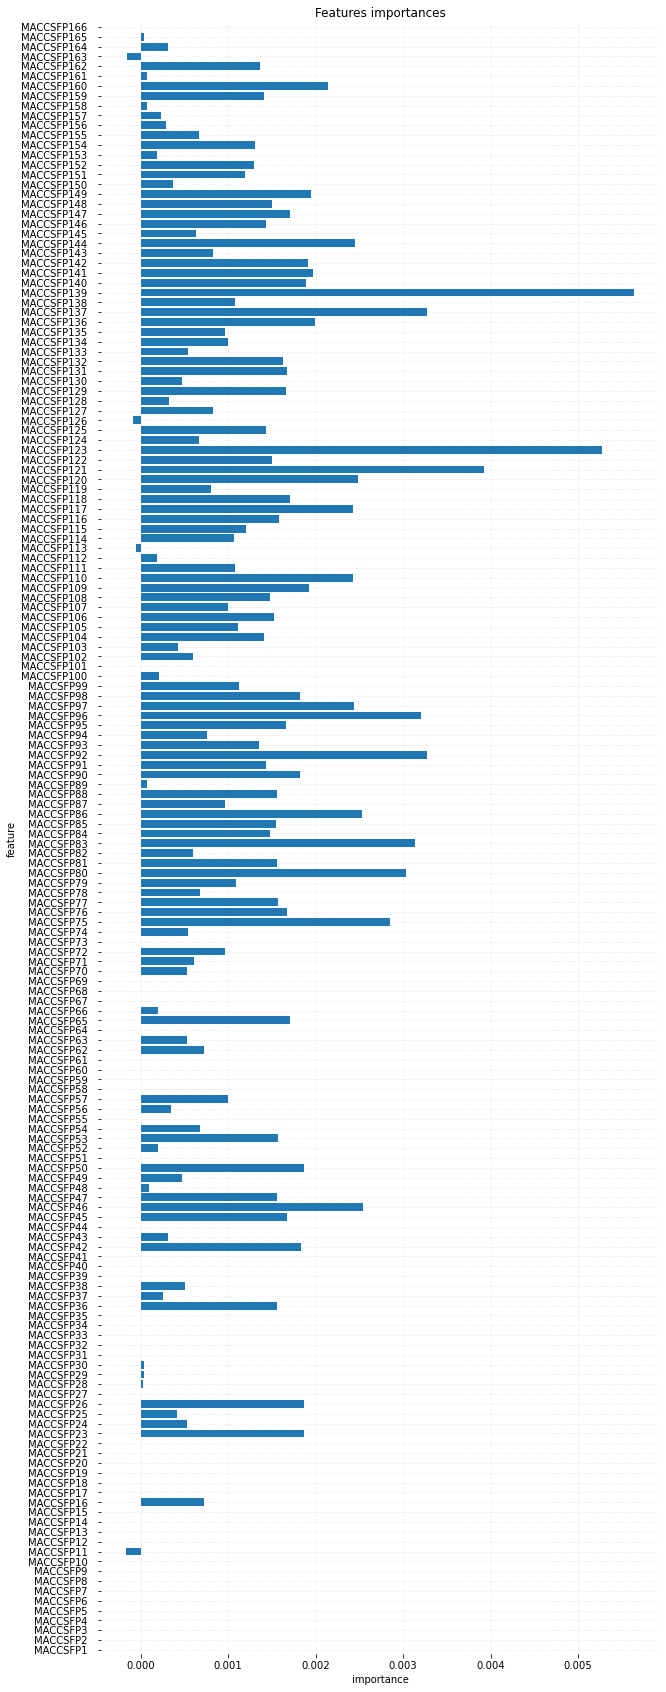

In [212]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [213]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415
2,XGBoost,7.094916,110.631212,10.518137,0.304240
3,LightGBM,9.181831,166.452713,12.901655,-0.046822
4,HistGradient Boosting Regressor,9.888441,180.920808,13.450681,-0.137812
5,Support Vector Regression,8.519874,129.696903,11.388455,0.184335


### Save models

In [46]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

## 4.7. Stacking models

### Averaging base models

In [215]:
def average_predictions(X):
    return ((0.25 * rf_best.predict(X)) + \
            (0.3 * xgbr_best.predict(X)) + \
            (0.15 * lgbm_best.predict(X)) + \
            (0.15 * hist_best.predict(X)) + \
            (0.15 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 7.058648462143765
MSE: 107.19079734195041
RMSE: 10.353298862775594
R2 Square 0.32587634489483597 

Train set:
MAE: 17.594587335218883
MSE: 1370.9649758968103
RMSE: 37.02654420678239
R2 Square 0.45751419112768 



In [216]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415
2,XGBoost,7.094916,110.631212,10.518137,0.304240
3,LightGBM,9.181831,166.452713,12.901655,-0.046822
4,HistGradient Boosting Regressor,9.888441,180.920808,13.450681,-0.137812
5,Support Vector Regression,8.519874,129.696903,11.388455,0.184335
6,Averaging base models,7.058648,107.190797,10.353299,0.325876


### Averaging base models with Meta-model

In [217]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [218]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,37.688715,28.269684,43.530125,41.352726,31.807295
1,35.305622,27.881416,36.166960,30.795268,27.297426
2,76.489163,81.454483,55.872298,59.587546,51.053320
3,37.688715,28.269684,43.530125,41.352726,31.807295
4,36.093459,23.920778,42.964301,41.298727,30.199851
...,...,...,...,...,...
72,38.877930,34.707302,45.200310,43.954316,35.699944
73,41.135420,45.535389,46.473930,44.967594,35.799669
74,36.783268,66.059692,46.881136,48.667578,43.410087
75,37.688715,28.269684,43.530125,41.352726,31.807295


In [229]:
params = {'alpha': 0.7} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 12.487276899806162
MSE: 265.7729339148803
RMSE: 16.302543786626686
R2 Square -0.6714477929217193 

Train set:
MAE: 8.032711597949
MSE: 391.5736055379737
RMSE: 19.78821885713754
R2 Square 0.8450557615490046 



In [230]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415
2,XGBoost,7.094916,110.631212,10.518137,0.304240
3,LightGBM,9.181831,166.452713,12.901655,-0.046822
4,HistGradient Boosting Regressor,9.888441,180.920808,13.450681,-0.137812
5,Support Vector Regression,8.519874,129.696903,11.388455,0.184335
6,Averaging base models,7.058648,107.190797,10.353299,0.325876
7,Base models + Meta-model,12.487277,265.772934,16.302544,-0.671448


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [232]:
params_rf = {'max_depth': 2, 'n_estimators': 15} 

params_xgb = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 5, 
          'min_child_weight': 12, 'n_estimators': 200, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.45, 'learning_rate': 0.01, 'max_depth': 5, 
          'min_child_samples': 1, 'n_estimators': 35, 'num_leaves': 35, 'reg_alpha': 0.5, 'reg_lambda': 0.01, 
          'subsample': 0.9}

params_hist = {'l2_regularization': 0.1, 'learning_rate': 0.005, 'max_depth': 35, 'min_samples_leaf': 1} 

params_svr = {'C': 6.5, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

In [234]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    
        
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 10348.090004444877
Model1 R2: -0.3036137169032658
Model2 MSE: 10584.258330942503
Model2 R2: -0.33336532031879007
Model3 MSE: 9411.660259003225
Model3 R2: -0.18564579620006194
Model4 MSE: 8651.79481735172
Model4 R2: -0.0899207868203431
Model5 MSE: 9919.649835378681
Model5 R2: -0.2496404251144293
Average MSE = 9783.090649424203
Average R2 = -0.23243720907137805
-------------- fold 2 --------------
Model1 MSE: 819.1703990050004
Model1 R2: -0.3745389753077044
Model2 MSE: 658.3658361115165
Model2 R2: -0.10471460253631548
Model3 MSE: 643.7836506678909
Model3 R2: -0.08024621078073668
Model4 MSE: 547.8179614860419
Model4 R2: 0.08078082368356798
Model5 MSE: 465.4201267352031
Model5 R2: 0.2190414779791343
Average MSE = 626.9115948011306
Average R2 = -0.05193549739241086
-------------- fold 3 --------------
Model1 MSE: 4139.853963030058
Model1 R2: 0.027496492741440948
Model2 MSE: 4599.602751079883
Model2 R2: -0.08050425144642337
Model3 MSE: 4065.90

In [235]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [236]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [237]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,38.757962,27.137539,45.293520,41.709472,30.199409
1,36.222334,46.849728,38.197184,32.699799,33.907952
2,139.611157,69.159164,97.272659,130.826994,42.708224
3,36.931229,30.302050,45.402149,43.820326,35.849924
4,34.099676,28.540310,42.544841,40.335441,30.800147
...,...,...,...,...,...
72,39.194117,39.699352,47.895701,46.749642,37.445745
73,51.368620,50.105743,45.480608,43.143576,35.199910
74,30.016330,44.301731,45.590598,45.824225,43.009699
75,36.506791,38.754356,45.906987,43.029844,36.400065


In [238]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,37.600040,40.402227,44.737331,43.136952,34.286930
1,39.116139,43.433000,51.197556,54.458160,42.606757
2,48.356593,48.469739,49.672378,49.820479,49.256552
3,44.925609,43.291164,45.552690,43.146466,39.270589
4,37.842182,36.658677,45.164367,43.907757,35.924290
5,52.190081,47.509621,55.408102,58.356375,36.269405
6,37.842182,36.658677,45.164367,43.907757,35.924290
7,48.356593,48.469739,49.672378,49.820479,49.256552
8,48.356593,48.469739,49.672378,49.820479,49.256552
9,46.871023,48.692924,46.511076,44.901340,35.950567


In [242]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 23.135316270292876
MSE: 754.3250010351661
RMSE: 27.464977717725645
R2 Square -3.74395507305385 

Train set:
MAE: 27.854903341933568
MSE: 2023.6170804539859
RMSE: 44.98463160295954
R2 Square 0.19926214889639082 



In [243]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,10.554770,209.604847,14.477736,-0.318206
1,Random Forest Regressor,8.847998,114.260424,10.689267,0.281415
2,XGBoost,7.094916,110.631212,10.518137,0.304240
3,LightGBM,9.181831,166.452713,12.901655,-0.046822
4,HistGradient Boosting Regressor,9.888441,180.920808,13.450681,-0.137812
5,Support Vector Regression,8.519874,129.696903,11.388455,0.184335
6,Averaging base models,7.058648,107.190797,10.353299,0.325876
7,Base models + Meta-model,12.487277,265.772934,16.302544,-0.671448
8,Base models + Meta-model + cv,23.135316,754.325001,27.464978,-3.743955
